# Analysis of Preprint Papers from the ArXiv

The website [arxiv.org](https://arxiv.org) is a popular database for scientific papers in STEM fields. ArXiv has its own classification system consisting of roughly 150 different categories, which are manually added by the authors whenever a new paper is uploaded. A paper can be assigned multiple categories.

The goal for this project is to develop a machine learning model which can predict the ArXiv category from a given title and abstract. The data set used here has been scraped from the [ArXiv API](https://arxiv.org/help/api) over several days, using the Python scraper `arxiv_scraper.py`.

To get a sense for how long the scraping takes, you can uncomment and run the script below.

In [1]:
#from arxiv_scraper import cat_scrape
#cat_scrape(
#    max_results_per_cat = 100, # maximum number of papers to download per category (there are ~150 categories)
#    file_path = "arxiv_data", # name of output file
#    batch_size = 100 # size of every batch - lower batch size requires less memory - must be less than 30,000
#)

Alternatively, I have downloaded metadata from about a million papers using this scraper (with `max_results_per_cat` = 10000), which can be freely downloaded below. This data set takes up ~1gb of space, however, so I've included many random samples of this data set as well:

* `arxiv` contains the main data set
* `arxiv_sample_1000` contains 1,000 papers
* `arxiv_sample_5000` contains 5,000 papers
* `arxiv_sample_10000` contains 10,000 papers
* `arxiv_sample_25000` contains 25,000 papers
* `arxiv_sample_50000` contains 50,000 papers
* `arxiv_sample_100000` contains 100,000 papers
* `arxiv_sample_200000` contains 200,000 papers
* `arxiv_sample_500000` contains 500,000 papers
* `arxiv_sample_750000` contains 750,000 papers

Choose your favorite below. Alternatively, of course, you can set it to be the file name of your own scraped data.

In [2]:
file_name = "arxiv_sample_1000"

We start by importing all the packages we will need and setting up a data directory.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # regular expressions
import pickle # enables saving data and models locally
import spacy as sp # used for lemmatising text
import wget # downloading files
import tarfile # dealing with compressed .tar.gz files

os.system("mkdir data") # create data directory

print("Packages loaded and data directory created.")

Packages loaded and data directory created.


<h2> Fetching data </h2>

We then download the chosen data set --- if you've already scraped your own data set then skip this stage.

In [4]:
url_start = f"https://filedn.com/lRBwPhPxgV74tO0rDoe8SpH/scholarly_data/"

# download the paper data
if not os.path.isfile(f'data/{file_name}.csv'):
    print(f"Downloading {file_name}.csv...", end = " ")
    wget.download(url_start + f"{file_name}.csv", out = f"data/{file_name}.csv")
    print("Done!")
else:
    print(f"{file_name}.csv already downloaded.")

arxiv_sample_1000.csv already downloaded.


Next, we download a list of all the arXiv categories and store them in `cats`.

In [5]:
# download a list of all the arXiv categories
if not os.path.isfile('data/cats.csv'):
    print("Downloading cats.csv...", end = " ")
    wget.download(url_start + "cats.csv", out = "data/cats.csv")
    print("Done!")
else:
    print("cats.csv already downloaded.")

# construct category dataframe and array
cats_df = pd.read_csv("data/cats.csv")
cats = np.asarray(cats_df['category'].values)

pd.set_option('display.max_colwidth', 50)
cats_df.head()

cats.csv already downloaded.


,category,description
0,astro-ph,Astrophysics
1,astro-ph.CO,Cosmology and Nongalactic Astrophysics
2,astro-ph.EP,Earth and Planetary Astrophysics
3,astro-ph.GA,Astrophysics of Galaxies
4,astro-ph.HE,High Energy Astrophysical Phenomena


Next up we load the data into a dataframe. This might take a little while.

In [6]:
def nan_if_empty(x):
    ''' Converts empty lists/arrays to NaNs, making it easier to detect by pandas. '''
    arr = np.asarray(x)
    if arr.size == 0:
        return np.nan
    else:
        return arr

def remove_non_cats(x):
    ''' Removes every string in x which does not occur in the list of arXiv categories. '''
    return np.intersect1d(np.asarray(x), cats)

def str_to_arr(x):
    ''' Converts a string to a numpy array. '''
    return np.asarray(re.sub('[\' \[\]]', '', x).split(','))

def clean_cats(x):
    ''' Composition of nan_if_empty, remove_non_cats and str_to_arr. Used to clean scraped data. '''
    return nan_if_empty(remove_non_cats(str_to_arr(x)))

In [7]:
# set up dataframe
df = pd.read_csv(f'data/{file_name}.csv', converters={'category': clean_cats})[['title', 'abstract', 'category']]

print(f"Loaded metadata from {df.shape[0]} papers. Here are some of them:")
pd.set_option('display.max_colwidth', 300)
df.sample(3)

Loaded metadata from 1000 papers. Here are some of them:


,title,abstract,category
815,Adsorbate dynamics on a silica-coated gold surface measured by Rydberg\n Stark spectroscopy,Trapping a Rydberg atom close to a surface is an important step towards the\nrealisation of many proposals of quantum information or hybrid quantum systems.\nOne of the challenges in these experiments is to overcome the electric field\nemanating from contaminations on the surface. Here we repo...,[physics.atom-ph]
535,A new approach to analyzing solar coronal spectra and updated\n collisional ionization equilibrium calculations. II. Additional ionization\n rate coefficients,"We have reanalyzed SUMER observations of a parcel of coronal gas using new\ncollisional ionization equilibrium (CIE) calculations. These improved CIE\nfractional abundances were calculated using state-of-the-art electron-ion\nrecombination data for K-shell, L-shell, Na-like, and Mg-like ions o...",[astro-ph]
303,Time-resolved Hall conductivity of pulse-driven topological quantum\n systems,We address the question of how the time-resolved bulk Hall response of a two\ndimensional honeycomb lattice develops when driving the system with a pulsed\nperturbation. A simple toy model that switches a valley Hall signal by breaking\ninversion symmetry is studied in detail for slow quasi-ad...,[cond-mat.mes-hall]


<h2> Cleaning the data </h2>

We next do some basic cleaning of the data and saves the dataframe to `<file_name>_df.pickle`.

In [8]:
df_clean = df.copy()

# drop rows with NaNs
df_clean.dropna(inplace=True)

# merge title and abstract
df_clean['clean_text'] = df_clean['title'] + ' ' + df_clean['abstract']

# remove punctuation marks
punctuation ='\!\"\#\$\%\&\(\)\*\+\-\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~'
df_clean['clean_text'] = df_clean['clean_text'].apply(lambda x: re.sub(punctuation, '', x))

# convert text to lowercase
df_clean['clean_text'] = df_clean['clean_text'].str.lower()

# remove numbers
df_clean['clean_text'] = df_clean['clean_text'].str.replace("[0-9]", " ")

# remove whitespaces
df_clean['clean_text'] = df_clean['clean_text'].apply(lambda x:' '.join(x.split()))

pd.set_option('display.max_colwidth', 300)
df_clean[['title', 'abstract', 'clean_text']].sample(3)

,title,abstract,clean_text
82,Monitoring communication outbreaks among an unknown team of actors in\n dynamic networks,"This paper investigates the detection of communication outbreaks among a\nsmall team of actors in time-varying networks. We propose monitoring plans for\nknown and unknown teams based on generalizations of the exponentially weighted\nmoving average (EWMA) statistic. For unknown teams, we propo...",monitoring communication outbreaks among an unknown team of actors in dynamic networks this paper investigates the detection of communication outbreaks among a small team of actors in time-varying networks. we propose monitoring plans for known and unknown teams based on generalizations of the e...
22,Making the most of electronic journals,"As most electronic journals available today have been derived from print\noriginals, print journals have become a vital element in the broad development\nof electronic journals publishing. Further dependence on the print publishing\nmodel, however, will be a constraint on the continuing develo...","making the most of electronic journals as most electronic journals available today have been derived from print originals, print journals have become a vital element in the broad development of electronic journals publishing. further dependence on the print publishing model, however, will be a c..."
305,Macroscopic equivalence for microscopic motion in a turbulence driven\n three-dimensional self-assembly reactor,"We built and characterised a macroscopic self-assembly reactor that agitates\nmagnetic, centimeter-sized particles with a turbulent water flow. By scaling up\nthe self-assembly processes to the centimeter-scale, the characteristic time\nconstant scale also drastically increases. This makes the...","macroscopic equivalence for microscopic motion in a turbulence driven three-dimensional self-assembly reactor we built and characterised a macroscopic self-assembly reactor that agitates magnetic, centimeter-sized particles with a turbulent water flow. by scaling up the self-assembly processes t..."


Our last text cleaning step is to lemmatise the text, which reduces all words to its base form. For instance, 'eating' is converted into 'eat' and 'better' is converted into 'good'. This usually takes a while to finish, so instead we're simply going to download a lemmatised version of your chosen data set. Alternatively, if you're dealing with your own scraped data set, you can uncomment the marked lines below.

In [9]:
def lemmatise(texts):
    ''' Lemmatise an iterable of strings. '''
    
    # import spacy's language model
    try:
        nlp = sp.load('en', disable=['parser', 'ner'])
    except:
        os.system("python -m spacy download en --user")
        nlp = sp.load('en', disable=['parser', 'ner']) 

    return np.asarray([' '.join(np.asarray([token.lemma_ for token in nlp(text)])) for text in texts])

In [10]:
df_lemm = df_clean.copy()

if not os.path.isfile(f"data/{file_name}_lemm.pickle"):
    
    #  uncomment if you want to do it the hard way, or if you're dealing with your own data set
    #df_lemm['clean_text'] = lemmatise(df_lemm['clean_text'])
    #with open(f"data/{file_name}_lemm.pickle", "wb") as pickle_out:
    #    pickle.dump(df_lemm, pickle_out)
    #print(f"Finished lemmatising, and also saved lemmatised dataframe to data/{file_name}_lemm.pickle.")
    
    # download lemmatised dataframe
    print(f"Downloading {file_name}_lemm.pickle...", end = " ")
    wget.download(url_start + f"{file_name}_lemm.pickle", out = f"data/{file_name}_lemm.pickle")
    print("Done!")
    
    # load lemmatised dataframe
    with open(f"data/{file_name}_lemm.pickle", "rb") as pickle_in:
        df_lemm = pickle.load(pickle_in)
    print(f"Loaded lemmatised dataframe from data/{file_name}_lemm.pickle.")
    
else:
    # load lemmatised dataframe
    with open(f"data/{file_name}_lemm.pickle", "rb") as pickle_in:
        df_lemm = pickle.load(pickle_in)
    print(f"Loaded lemmatised dataframe from data/{file_name}_lemm.pickle.")

pd.set_option('display.max_colwidth', 300)
df_lemm.sample(3)

Loaded lemmatised dataframe from data/arxiv_sample_1000_lemm.pickle.


,title,abstract,category,clean_text
181,Unary Primitive Recursive Functions,"In this article, we study some new characterizations of primitive recursive\nfunctions based on restricted forms of primitive recursion, improving the\npioneering work of R. M. Robinson and M. D. Gladstone in this area. We reduce\ncertain recursion schemes (mixed/pure iteration without paramet...","[cs.LO, cs.SC]","unary primitive recursive function in this article , -PRON- study some new characterization of primitive recursive function base on restricted form of primitive recursion , improve the pioneering work of r. m. robinson and m. d. gladstone in this area . -PRON- reduce certain recursion scheme ( m..."
979,The Algebra of Filters of a Cubic Algebra,"In this paper we discuss the inclusion ordering on the filters of a filter\nalgebra, a special type of Metropolis-Rota algeba. Using embeddings into\ninterval algebras we show that the notion of ""untwisted"" gives rise to a\ncongruence relation on the group of g-filters. We also show that there...","[math.CO, math.RA]","the algebra of filter of a cubic algebra in this paper -PRON- discuss the inclusion order on the filter of a filter algebra , a special type of metropolis - rota algeba . use embedding into interval algebra -PRON- show that the notion of "" untwisted "" give rise to a congruence relation on the gr..."
792,Data-Driven Tree Transforms and Metrics,"We consider the analysis of high dimensional data given in the form of a\nmatrix with columns consisting of observations and rows consisting of features.\nOften the data is such that the observations do not reside on a regular grid,\nand the given order of the features is arbitrary and does no...","[cs.LG, q-bio.QM, stat.ML]","datum - drive tree transform and metric -PRON- consider the analysis of high dimensional datum give in the form of a matrix with column consist of observation and row consist of feature . often the datum be such that the observation do not reside on a regular grid , and the give order of the fea..."


## One-hot encoding of categories

We then perform a one hot encoding for the category variable, as this will make training our model easier. We do this by first creating a dataframe with columns the categories and binary values for every paper, and then concatenate our original dataframe with the binary values.

In [18]:
def cats_to_binary(categories):
    '''
    Takes an iterable of categories and returns an array with 1 at the category indexes and zeros everywhere else.
    
    INPUT
        iterable of categories
    
    OUTPUT
        numpy array with 1 at the category indexes and zeros everywhere else
    '''
    return np.in1d(cats, categories).astype('int8')

print("One-hot encoding...", end = " ")

df_1hot = df_lemm.copy()

# populate cats_df with the information from df
bincat_arr = np.array([cats_to_binary(cat_list) for cat_list in df_1hot['category']]).transpose()
bincat_dict = {key:value for (key,value) in zip(cats, bincat_arr)}
bincat_df = pd.DataFrame.from_dict(bincat_dict)

# concatenate df with the columns in cats_df
df_1hot = pd.concat([df_1hot, bincat_df], axis=1, sort=False)

# drop the category column
df_1hot.drop(['category'], axis=1, inplace=True)

print("Done!")

# show the new columns of the data frame
pd.set_option('display.max_colwidth', 10)
df_1hot.head()

One-hot encoding... Done!


,title,abstract,clean_text,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,On inv...,In t...,on inv...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,On a p...,A th...,on a p...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Restri...,In t...,restri...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Counti...,We c...,count ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Curren...,We p...,curren...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2> Analysis of the data </h2>

Here is how the categories in our data set are distributed.

In [12]:
# save a dataframe with the amount of papers in each category
sum_cats = bincat_df.apply(lambda x: x.sum())

# get statistical information about the distribution of the amount of papers
sum_cats.describe()

count    153.00...
mean     14.450980
std      11.656792
min       0.000000
25%       5.000000
50%      12.000000
75%      20.000000
max      55.000000
dtype: float64

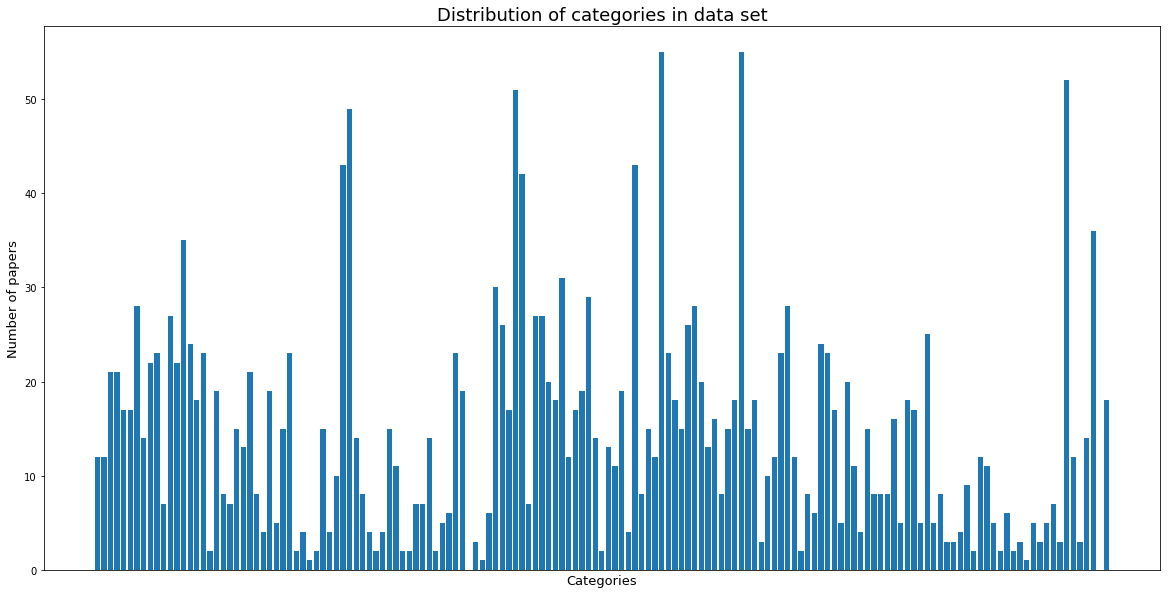

In [13]:
# plot the distribution of the amount of papers in each category
plt.figure(figsize=(20,10))
plt.bar(x=sum_cats.keys(), height=sum_cats.values)
plt.xlabel('Categories', fontsize=13)
plt.ylabel('Number of papers', fontsize=13)
plt.title('Distribution of categories in data set', fontsize=18)
plt.xticks([])
plt.show()

We see that our data is not particularly uniformly distributed. These are the categories with the most amount of papers in the data set.

In [14]:
# add the counts to the dataframe and sort 
cats_df['count'] = sum_cats.values
cats_df = cats_df.sort_values(by=['count'], ascending=False)

pd.set_option('display.max_colwidth', 50)
cats_df.head()

,category,description,count
85,math.MP,Mathematical Physics,55
97,math-ph,Mathematical Physics,55
146,quant-ph,Quantum Physics,52
63,hep-ph,High Energy Physics - Phenomenology,51
38,cs.LG,Learning,49


<h2> ELMo feature extraction </h2>

To build our model we have to extract features from the titles and abstracts. We will be using ELMo, a state-of-the-art NLP framework developed by AllenNLP, which converts text input into vectors, with similar words being closer to each other. We will need the following extra packages.

Next, we download the ELMo model. It is over 350mb in size, so it might take a little while.

In [ ]:
if not os.path.isdir("elmo"):
    # download ELMo model
    print("Downloading compressed ELMo model...", end = " ")
    url = "https://tfhub.dev/google/elmo/2?tf-hub-format=compressed"
    wget.download(url, out="elmo.tar.gz")
    print("Done!")

    # uncompress ELMo model
    print("Uncompressing into the 'elmo' directory...", end = " ")
    os.system("mkdir elmo") # create directory
    with tarfile.open("elmo.tar.gz") as tar:
        tar.extractall("elmo")
    os.remove("elmo.tar.gz")
    print("Done!")
else:
    print("The 'elmo' directory already exists, so assuming that the model has been downloaded.")

We now need to extract ELMo features from our cleaned text data. This is done using the `extract` function from `elmo.py`. This usually takes a LONG time.

In [ ]:
from elmo import extract

if not os.path.isfile(f"data/{file_name}_elmo.pickle"):
    # extract ELMo data
    elmo_data = extract(
        df_1hot['clean_text'], 
        batch_size = 10 # lower batch size gives less accurate vectors but requires less RAM
    )

    # save ELMo data
    with open(f"data/{file_name}_elmo.pickle", "wb") as pickle_out:
        pickle.dump(elmo_data, pickle_out)

    print(f"ELMo extraction completed. Also saved elmo data to data/{file_name}.elmo.pickle.")
else:
    # load ELMo data
    with open(f"data/{file_name}_elmo.pickle", "rb") as pickle_in:
        elmo_data = pickle.load(pickle_in)

    print(f"ELMo data loaded from data/{file_name}_elmo.pickle.")

print(f"Dimensions of elmo_data: {elmo_data.shape}")

df_elmo = pd.DataFrame(elmo_data)
df_elmo = df_elmo.join(pd.DataFrame(df_1hot.drop(columns=['title', 'abstract', 'clean_text'])))
df_elmo.head()

<h2> Building the model </h2>

We are now done manipulating our data, and the time has come to build a model. We will be building a logistic regression model for every category.

<h2> Testing the model </h2>

We now check whether our model is capable of predicting the categories for the papers in our test set.